# Temperatura externa y consumo de energía

A continuación vamos a modelar el consumo de energía de un conjunto de edificios usuando como variable de entrada la temperatura externa

## Cargamos las librerías 

Importamos todas las librerías de una vez, desde las que nos van a ayudar con la carga, limpieza y preparación de datos, las que nos crearán y procesarán el modelo y finalmente las que nos darán idea del éxito del modelo además de visualización del modelo y los datos.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import calendar

import glob

from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d

sns.set()
pd.set_option('mode.chained_assignment', None)

## Cargamos los datos desde un directorio local

Se cargan los datos desde un directorio local ya creado, se puede traer directamente cada archivo con wget de tal manera que no sea necesario hacer esto, pero este método tampoco tiene ningún problema en este caso, solo cambia la forma como se descargaron los datos.

In [2]:
ruta_archivos='Datos' #Ruta de los datos
archivos_totales = glob.glob(ruta_archivos + "/*.csv") #Librería glob que permite almacenar todas las rutas en una lista

df_individuales = [] #Lista para crear un df con cada archivo
for nombre_archivo in archivos_totales: #Ciclo para leer cada archivo
    df_individual = pd.read_csv(nombre_archivo,sep=',') #Creación de dataframes
    df_individuales.append(df_individual) #Lista de los dataframes


## Unimos todos los datos

Se concatenan todos los archivos que estaban en 5 distintos dataframes en uno solo

In [3]:
df=pd.concat(df_individuales) #Unimos todos los dataframes en uno

## Exploración de datos y limpieza de datos

### Vista inicial

A continuación vamos a observar cuál es el estado de nuestro dataset, esto quiere decir, con cuales datos contamos, qué tipo de relaciones podemos establecer, como varían las distintas variables que tenemos y de la misma manera, qué datos podemos y debemos usar de estas variables para evitar la mayor cantidad de errores asociados a la estructura y forma de nuestros datos, evitando tomar datos que entorpezcan nuestro análisis. 

In [4]:
df #despliegue visual del dataframe

,Timestamp,OAT (F),Power (kW)
0,1/1/2010 1:15,51,165.1
1,1/1/2010 1:30,51,151.6
2,1/1/2010 1:45,51,146.9
3,1/1/2010 2:00,51,153.7
4,1/1/2010 2:15,51,153.8
...,...,...,...
34935,12/30/2010 23:00,67,333.7
34936,12/30/2010 23:15,68,221.0
34937,12/30/2010 23:30,68,235.7
34938,12/30/2010 23:45,68,227.2


### Descripción y estructura de datos

Vemos que contamos con:

**1. Columna indicial** <br>
**2. Columna de fechas** <br>
**3. Columna que indica la temperatura externa(Outside average temperature)** <br>
**4. Columna que indica el consumo de energía en kW** <br>

Esta descripción es la que nos ayudará a crear las relaciones entre las distintas variables al conocer de que se trata, pero aún nos falta determinar la estructura de datos que tiene cada columna, esto con el fin de realizar una limpieza adecuada de datos en caso de que alguna columna no tenga la estructura que queremos, por ejemplo que la temperatura la esté interpretando como una cadena de caracteres (*string*) y no como una numérica (*int* o *float*) o la fecha en un formato no interpretable por las librerías para un análisis temporal.

In [5]:
df.dtypes

Timestamp      object
OAT (F)         int64
Power (kW)    float64
dtype: object

Vemos que las columnas relacionadas con datos numéricos (temperatura y consumo energético) tienen una estructura de datos adecuado (*int* y *float* lo cual nos da a entender también la precisión que tienen los datos) pero la columna de fechas tiene un formato muy genérico tipo object, lo cual puede presentar serios problemas con otras librerías o para nuestra extracción de datos relevantes dado que los comandos no interpretarían de forma adecuada dicho formato o de lo contrario tocaría hacer un algoritmo muy especializado y sería un derroche de timpo y computacional innecesario. Para lidiar con esto se pudo haber puesto la columna de fechas como índice y haber hecho un parse_dates=True cuando leímos el csv, o solamente haber añadido el parse_dates indicando la columna de fechas para poner en el formato. Pero dada la aproximación que usamos de este problema donde no asumimos nada de la estructura de datos del dataframe, esta parte de la limpieza de datos la haremos ahora mismo donde en teoría apenas sabemos que dichos datos tienen la estructura tipo *object*, de igual manera vamos a renombrar la columna (en inglés para conservar el idioma) de TimeStamp por si es necesario en algún momento regresar el archivo inicial en el formato preparado a un cliente final enfocado en negocio.

In [6]:
df=df.rename(columns={'Timestamp':'Date'}) #Renombramos la columna
df['Date']=pd.to_datetime(df['Date'],infer_datetime_format=True) #Hacemos uso del comando to_datetime de pandas para ponerlo en nuestro formato

Verificamos para la columna que queremos ver la estructura de sus datos

In [7]:
df.dtypes['Date']

dtype('<M8[ns]')

La estructura *M8[ns]* es una estructura relacionada directamente con la estructura *datetime64[ns]* que es la usual que arroja en estos casos cuando observamos todo el dataframe, solamente que la *M8[ns]* es de tipo específico, pero para la máquina tiene una interpretación igual dado que su estructura está regida a *datetime64[ns]* en general, por lo tanto vemos que logramos una conversión adecuada para nuestra columna que tenía un formato poco amigable para el análisis

Pero dado a que tomamos distintos conjuntos de datos, una parte del análisis de datos adicional si se quisiera, puede ser ver como difieren o cambia la estadística dependiendo del edificio que tenemos y sí, es prudente unificarlos todos para realizar el modelo y tener una mejor cantidad de dato o por el contrario estamos tomando conjuntos de datos tan dispares entre sí que en realidad estamos realizando un paso en falso en el análisis. Por lo tanto hagamos esta transformación para cada dataset. En general esto es un costo computacional extra que el mismo parse_dates ahorra, pero también es de entender que no siempre este tipo de análisis es necesario pues precisamente se quiere ver una imagen general, en este caso se hará solo por el hecho de que se puede hacer y el objetivo final no tiene que ver exclusivamente con una vista general del comportamiento sino que podemos también dedicarle un espacio a este análisis particular de los datasets y el código es simple de generalizar, además de que en general hasta ahora no hemos tenido que usar indicialmente la columna de fechas.

In [8]:
for i in range(len(df_individuales)):
    df_individuales[i]=df_individuales[i].rename(columns={'Timestamp':'Date'})
    df_individuales[i]['Date']=pd.to_datetime(df_individuales[i]['Date'],infer_datetime_format=True)

### Visualización de datos iniciales

Hecho esto veamos una gráfica de nuestros datos que usaremos como variables, o sea la temperatura y el consumo de energía y darnos una idea gráfica de como se dan de bruscas o suaves las variaciones y depronto ver tendencias si es posible.

<AxesSubplot:>

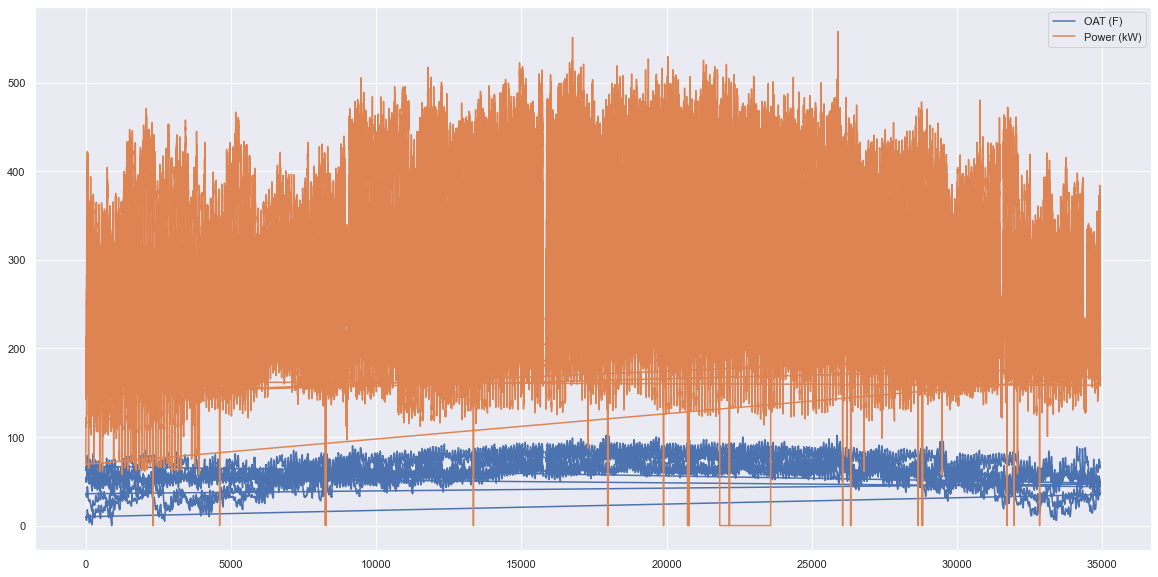

In [9]:
df[['OAT (F)','Power (kW)']].plot(figsize=(20,10))

Claramente hay lineas que se cruzan de una manera completamente anormal o puntos de transición bastante extraños, una idea de esto es que como no usamos de índice la fecha lo cual hubiera ordenado automáticamente los datos en forma ascendente (de menor fecha a mayor fecha). Por esto vemos que tenemos un motivo de usar la fecha como índice y eliminar el índice numérico inicial que no nos aporta nada, a veces es prudente usar este índice cuando queremos recuperar algún tipo de información inicial, pero este no es nuestro caso, también se puede simplemente ordenar el dataframe de acuerdo a la columna de fecha y obtendríamos el mismo resultado.

In [10]:
df=df.set_index(['Date']) #Comando para asignar columna o columnas como índice

Dejemos también la columna de fechas como índice de nuevo para cada dataframe por si se quiere hacer el análisis particular de cada dataset

In [11]:
for i in range(len(df_individuales)):
    df_individuales[i]=df_individuales[i].set_index(['Date'])

Graficando de nuevo

<AxesSubplot:xlabel='Date'>

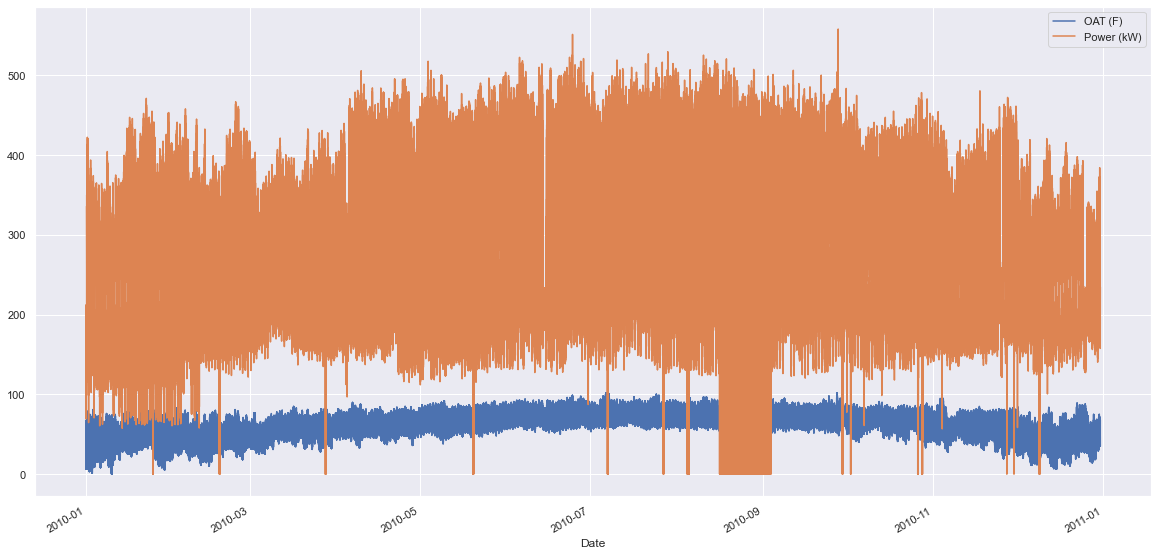

In [12]:
df.plot(figsize=(20,10)) #Volvemos a realizar nuestro gráfico, ya no es necesario especificar las columnas

Como podemos observar ya todos los puntos siguen una estructura secuencial aparentemento, pero sigue habiendo comportamiento extraños, como por ejemplo fechas donde no hubo consumo energético, lo cuál hace primero sospechar de cuales datos existen en este dateset. En general sería solo eliminar los datos sospechosos, por ejemplo aquellos que no cumplan una regla que establezcamos, pero dado que tenemos la oportunidad, hagamos el análisis de cada dataset, del cual hablamos anteriormente.

### Estadística descriptitiva general y particular

Veamos la estadística descriptiva para cada dataset y para el conjunto de datos en general y veamos si hay cuestiones extrañas 

Veamos la estadística descriptiva para el dataset general

In [13]:
descriptiva_completa=df.describe()

Y para el caso particular

In [14]:
descriptiva_individual=[]
for i in range(len(df_individuales)):
    descriptiva_individual.append(df_individuales[i].describe())

Veamos la siguiente regla simple para ver que tanto difiere nuestros datasets, esto es si la medias de alguno en particular excede por más de una desviación estandar la media del completo, pues esto quiere decir que la distribución de cada dataset se empezaría a ubicar en un lugar más lejano del esperado pues estaría tan desbalanceado que sería importante ver la razón si es por algo esperado y las variables se siguen comportando igual o por el contrario tiene un comportamiento particular distinto a los demás

In [15]:
for i in range(len(descriptiva_individual)):
    if ((descriptiva_individual[i].loc['mean']['OAT (F)']>(descriptiva_completa.loc['mean']['OAT (F)']+descriptiva_completa.loc['std']['OAT (F)'])) | (descriptiva_individual[i].loc['mean']['OAT (F)']<(descriptiva_completa.loc['mean']['OAT (F)']-descriptiva_completa.loc['std']['OAT (F)']))):
        print('El dataset {} tiene una media de temperatura alejada por más de una desviación estandar del completo'.format(i+1))
    else:
        print('El dataset {} tiene una media de temperaturas entre los márgenes de las desviaciones del completo'.format(i+1))
        
    if ((descriptiva_individual[i].loc['mean']['Power (kW)']>(descriptiva_completa.loc['mean']['Power (kW)']+descriptiva_completa.loc['std']['Power (kW)'])) | (descriptiva_individual[i].loc['mean']['Power (kW)']<(descriptiva_completa.loc['mean']['Power (kW)']-descriptiva_completa.loc['std']['Power (kW)']))):
        print('El dataset {} tiene una media de energías alejada por más de una desviación estandar del completo'.format(i+1))
    else:
        print('El dataset {} tiene una media de energías entre los márgenes de las desviaciones del completo'.format(i+1))

El dataset 1 tiene una media de temperaturas entre los márgenes de las desviaciones del completo
El dataset 1 tiene una media de energías entre los márgenes de las desviaciones del completo
El dataset 2 tiene una media de temperaturas entre los márgenes de las desviaciones del completo
El dataset 2 tiene una media de energías entre los márgenes de las desviaciones del completo
El dataset 3 tiene una media de temperaturas entre los márgenes de las desviaciones del completo
El dataset 3 tiene una media de energías entre los márgenes de las desviaciones del completo
El dataset 4 tiene una media de temperaturas entre los márgenes de las desviaciones del completo
El dataset 4 tiene una media de energías entre los márgenes de las desviaciones del completo
El dataset 5 tiene una media de temperaturas entre los márgenes de las desviaciones del completo
El dataset 5 tiene una media de energías entre los márgenes de las desviaciones del completo


Las técnicas para ver conjuntos de datos balanceados son mucho más amplias y complejas que esta, que en sí puede contener muchos errores pues una diferencia significativa entre medias o solamente usar una desviación no es un criterio universal y que es necesario justificar la razón de usar la regla, cosa que se hizo de forma muy simple en este caso, aún así encontramos conjuntos de datos relativamente similares dado este pequeño análisis estadístico, y nos da un indicio almenos de hacer un tratamiento general de los dataset y no tener que hacer un análisis para cada uno de éstos de manera particular y de esta manera siendo más general a la hora de observar el fenómeno como también ahorrando y siendo eficiente computacionalmente hablando, otras técnicas implican mejores reglas o fórmulas estadísticas para verificar la relación de los datos o la toma de muestras aleatorias o con ciertas condiciones dadas las variables.

### Pureza de los datos y datos relevantes 

Revisar las propiedades de los datos. Especificamente revisamos si hay valores faltantes. Para esto vemos cuantos valores nan (nulos o faltantes) hay en cada columna de nuestro dataset

In [16]:
df.isna().sum()

OAT (F)       0
Power (kW)    0
dtype: int64

También podríamos haber eliminado de forma inicial las columnas con valores nan de entrada así:

In [17]:
df=df.dropna()

Que para nuestro caso nos arroja el mismo número de columnas que si no hubiéramos aplicado la función, esto es recomendable si ya sabemos que queremos eliminar nuestras filas con valores faltantes o cuestiones relacionados con esto, pero no si queremos hacer un análisis sobre los mismos valores faltantes o hacer algún tipo de tratamiento tipo reemplazo o filtro con los que nos arroje esto, no se debe implementar.

Independientemente del método concluimos que no hay valores faltantes, pero esto no asegura que los valores que estén asignados sean importantes, aún así ya verificamos la integridad de nuestros datos en este aspecto

¿Cuál es el comportamiento de los datos? Hagamos un histograma y gráfico de caja que nos muestre graficamente como se encuentra la distribución y dispersión de los datos de acuerdo a su distribución

array([[<AxesSubplot:title={'center':'OAT (F)'}>,
        <AxesSubplot:title={'center':'Power (kW)'}>]], dtype=object)

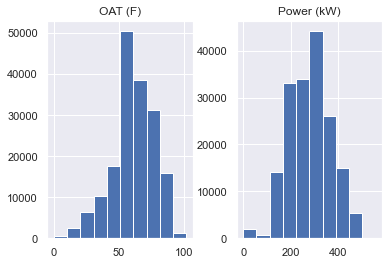

In [18]:
df.hist()

Text(0.5, 1.0, 'Gráfico de caja de las variables')

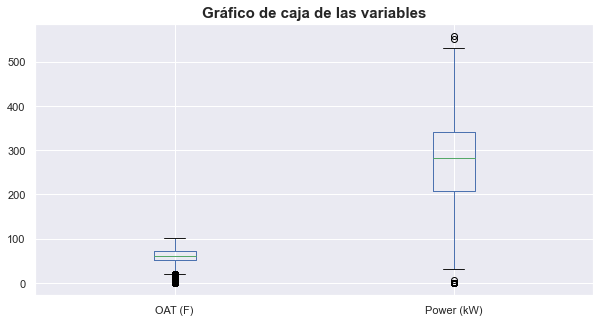

In [19]:
df.plot(kind='box', figsize=(10,5))
plt.title('Gráfico de caja de las variables',fontweight='bold',fontsize=15)

Vamos a limpiar nuestros datos usando la regla de las n desviaciones estandar.Esta es una regla muy adecuada pues nos ayuda a estimar la cantidad de datos (desigualdad de Chebychev), y hallar esto es lo mismo que establecer el mínimo valor $z$

$$
z = \frac{x-\mu}{\sigma}
$$

In [20]:
desviaciones=[0,1,2,3,4]
df_depurado=[]
df_normal=[]
cantidad_datos_df=[]
for i in range(len(desviaciones)):
    df_depurado.append(df.loc[(np.abs(stats.zscore(df)) > desviaciones[i]).any(axis=1)].sort_index())
    df_normal.append(df.loc[(np.abs(stats.zscore(df)) < desviaciones[i]).all(axis=1)].sort_index())
    cantidad_datos_df.append(len(df_depurado[i]))
    print(len(df_normal[i]))
cantidad_datos_df

0
86595
161270
172034
174700


[174700, 88105, 13430, 2666, 0]

La cantidad de datos nos indica de que para tener datos debemos tener máximo 3 desviaciones estandar, de lo contrario no hay datos tan extremos que nos permita establecer relaciones. Veamos esto graficamente si podemos evidenciar una disminución de ruido

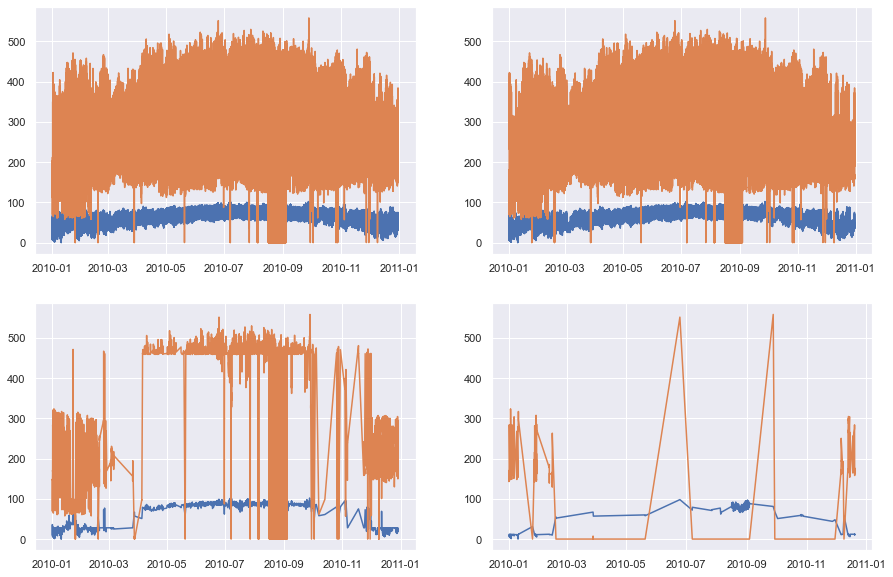

In [21]:
fig1,ax1=plt.subplots(2,2,figsize=(15,10))

ax1[0][0].plot(df_depurado[0])
ax1[0][1].plot(df_depurado[1])
ax1[1][0].plot(df_depurado[2])
ax1[1][1].plot(df_depurado[3])

Veamos en un gráfico de dispersión:

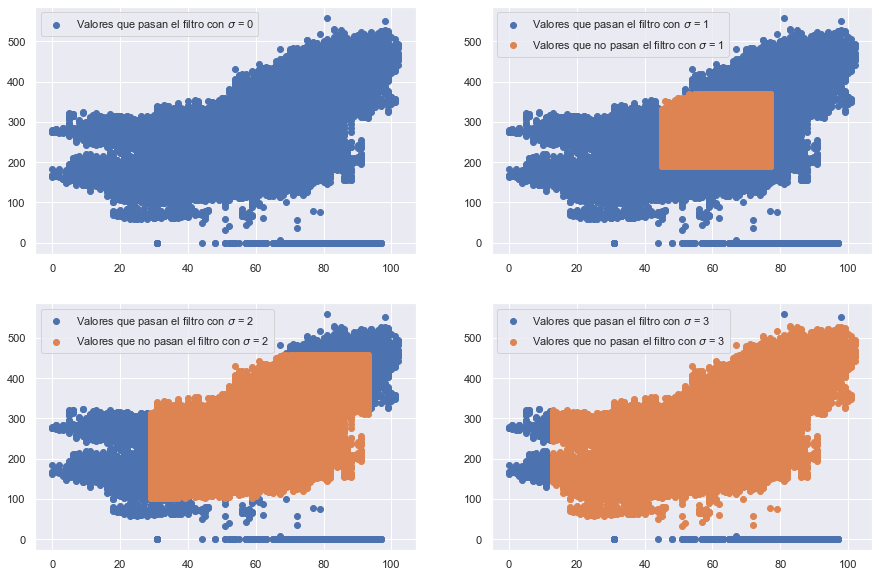

In [22]:
fig2,ax2=plt.subplots(2,2,figsize=(15,10))

ax2[0][0].scatter(df_depurado[0]['OAT (F)'],df_depurado[0]['Power (kW)'],label='Valores que pasan el filtro con $\sigma$ = 0')
ax2[0][1].scatter(df_depurado[1]['OAT (F)'],df_depurado[1]['Power (kW)'],label='Valores que pasan el filtro con $\sigma$ = 1')
ax2[1][0].scatter(df_depurado[2]['OAT (F)'],df_depurado[2]['Power (kW)'],label='Valores que pasan el filtro con $\sigma$ = 2')
ax2[1][1].scatter(df_depurado[3]['OAT (F)'],df_depurado[3]['Power (kW)'],label='Valores que pasan el filtro con $\sigma$ = 3')

ax2[0][1].scatter(df_normal[1]['OAT (F)'],df_normal[1]['Power (kW)'],label='Valores que no pasan el filtro con $\sigma$ = 1')
ax2[1][0].scatter(df_normal[2]['OAT (F)'],df_normal[2]['Power (kW)'],label='Valores que no pasan el filtro con $\sigma$ = 2')
ax2[1][1].scatter(df_normal[3]['OAT (F)'],df_normal[3]['Power (kW)'],label='Valores que no pasan el filtro con $\sigma$ = 3')

ax2[0][0].legend()
ax2[0][1].legend()
ax2[1][0].legend()
ax2[1][1].legend()


Como podemos observar esto claramente sucede graficamente, la cantidad de datos empieza a mostrar comportamientos distintos cuando dejamos de tomar los datos cotidianos pero a su vez sin tomar los errores estadísticos (segunda desviación estandar) y que en general exhiben comportamientos valiosos de examinar, de esta manera apliquemos otro filtro sobre el subconjunto de datos que hemos tomado como extremos, de eliminar aquellos datos que tengan consumo energético que ya hemos caracterizado como error de la medición ¿Por qué? esto debido a qué en este caso no hay correlación de manera analítica entre la temperatura y consumo energético y podemos decir que en realidad se debe a valores externos completamente, ya que un consumo energético nulo por ejemplo solo implica que en esos momentos puntuales no hay una persona que varíe la energía por lo tanto no se puede asociar ninguna variable en absoluto (depronto alguna que nos indique habitabilidad o daño en los contadores de energía o algún factor semejante, de lo contrario son datos completamente inconexos que lo único que hacen es sesgar el modelo). 

In [23]:
df=df_normal[3]
df_limpio=df_depurado[2].loc[~((df_depurado[2]['Power (kW)'].isin(df_depurado[3]['Power (kW)']))&(df_depurado[2]['OAT (F)'].isin(df_depurado[3]['OAT (F)'])))]

Graficando los nuevos conjuntos de datos (el completo y el de valores extremos) con la nueva limpieza añadida tenemos lo siguiente

Text(0.5, 1.0, 'Representación de la dependencia de las variables')

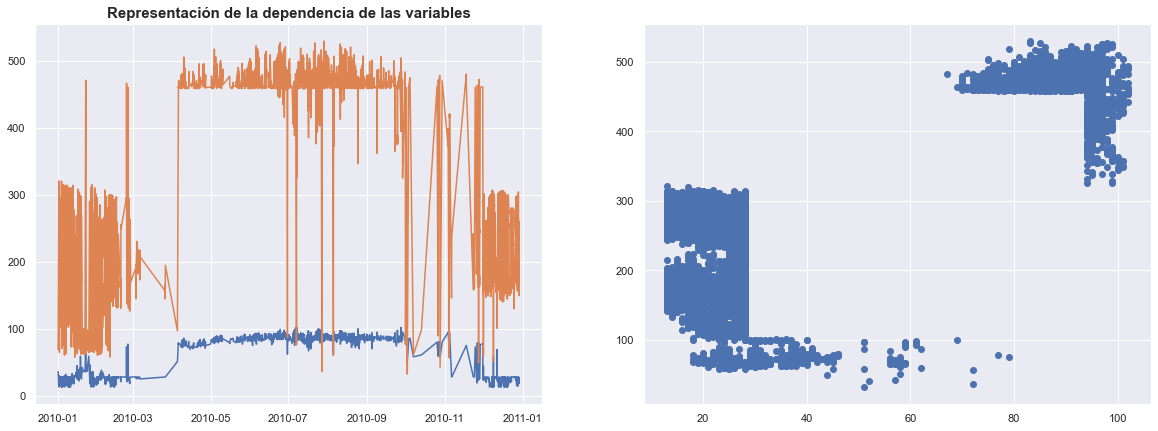

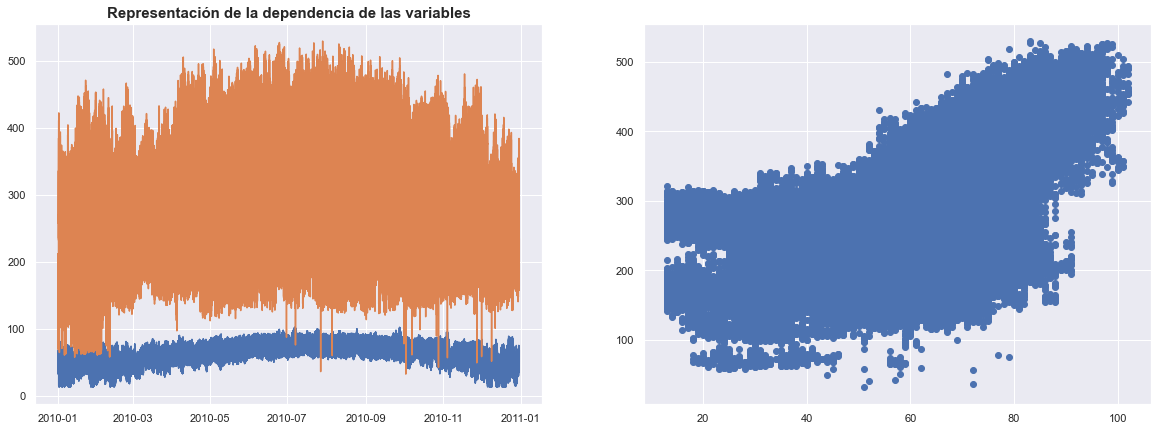

In [24]:
fig3,ax3=plt.subplots(1,2,figsize=(20,7))

ax3[0].plot(df_limpio)
ax3[1].scatter(df_limpio['OAT (F)'],df_limpio['Power (kW)'])
ax3[0].set_title('Evolución temporal de las variables depuradas',fontweight='bold',fontsize=15)
ax3[0].set_title('Representación de la dependencia de las variables',fontweight='bold',fontsize=15)

fig4,ax4=plt.subplots(1,2,figsize=(20,7))

ax4[0].plot(df)
ax4[1].scatter(df['OAT (F)'],df['Power (kW)'])
ax4[0].set_title('Evolución temporal de las variables depuradas',fontweight='bold',fontsize=15)
ax4[0].set_title('Representación de la dependencia de las variables',fontweight='bold',fontsize=15)

Con estos datos filtrados de esta manera, en la cual hemos depurado de forma uniforme para cada variable, tal qué hemos seleccionado solo los casos extremos para alguno de los casos, vemos almenos de manera gráfica que los valores extremos solo se asocian de manera directa con su correspondiente valor igual de bajo, esto nos empieza a hacer una idea de nuestro ajuste. Es posible argumentar que seleccionar los datos de esta manera es conveniente pues solo se toman los datos que darán un buen ajuste, pero esto se puede contestar observando que la selección de datos se hizo basándose en el valor de z de acuerdo a las desviaciones estandar, esto quiere decir qué, de existir el caso, podría existir una asociación entre valores muy altos de la temperatura y cualquiera de la energía o visceversa, así que no es que sea exactamente una extracción conveniente sino que en los valores más representativos de la relación entre variables son de acuerdo a lo esperado. No se tomaron para ambos casos simultaneamente, qué debería dar un mucho mejor o mucho peor ajuste, debido qué a la hora de dar una hipótesis respecto a la temperatura tendríamos que condicionar el hecho qué el consumo energético fuera igualmente alto o bajo, cosa que no es altamente parametrizable si queremos usar el modelo y sería una condición bastante restrictiva.

Así hemos limpiado los datos de manera general para cuestiones que podemos asociar a errores de medición ,pero además hemos creado un subconjunto de datos, mayor a los solamente eliminados en los cuáles están los valores extremos de z, los cuales también son una variable relevante, pues podemos observar el comportamiento en casos de valores extremos sin que estos estén influenciados por lo que hemos marcado como errores de medición y así nos puede servir para otros análisis.

Veamos como se relacionan los datos del dataset general para un conjunto de fechas, esto para ver si existe algún tipo de comportamiento en específico de los datos en su evolución temporal respecto a las horas y depronto determinar nuevas variables a partir de esto

<AxesSubplot:xlabel='Date'>

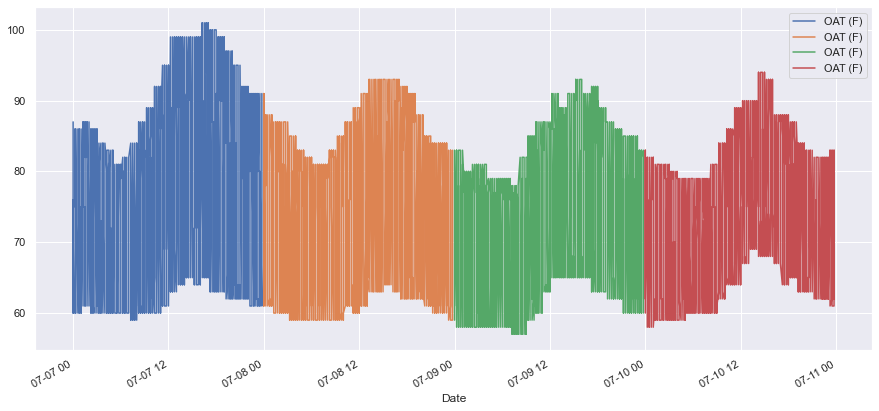

In [25]:
fig, ax = plt.subplots(figsize=(15,7))
df.loc['2010-07-07', ['OAT (F)']].plot(ax=ax)
df.loc['2010-07-08', ['OAT (F)']].plot(ax=ax)
df.loc['2010-07-09', ['OAT (F)']].plot(ax=ax)
df.loc['2010-07-10', ['OAT (F)']].plot(ax=ax)

<AxesSubplot:xlabel='Date'>

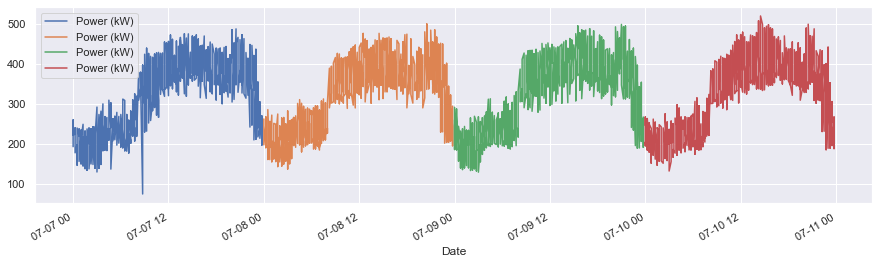

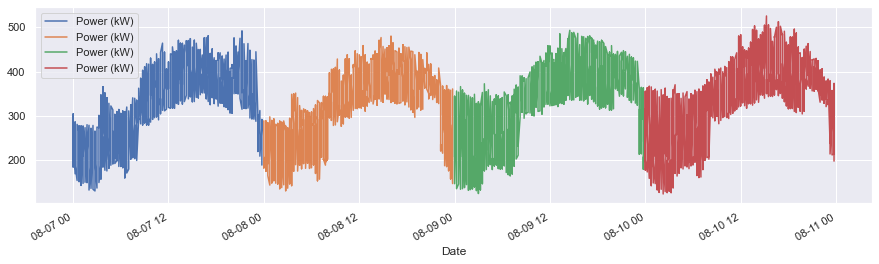

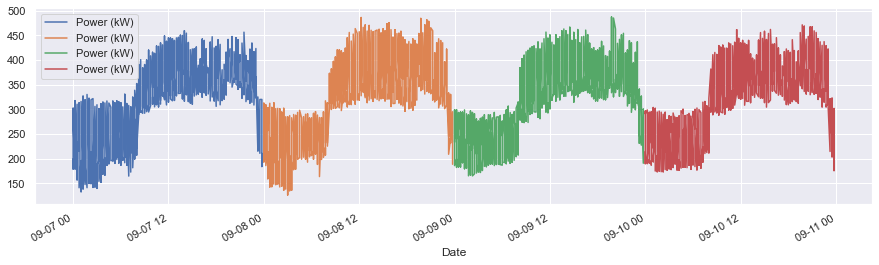

In [26]:
fig, ax = plt.subplots(figsize=(15,4))
df.loc['2010-07-07', ['Power (kW)']].plot(ax=ax)
df.loc['2010-07-08', ['Power (kW)']].plot(ax=ax)
df.loc['2010-07-09', ['Power (kW)']].plot(ax=ax)
df.loc['2010-07-10', ['Power (kW)']].plot(ax=ax)

fig, ax = plt.subplots(figsize=(15,4))
df.loc['2010-08-07', ['Power (kW)']].plot(ax=ax)
df.loc['2010-08-08', ['Power (kW)']].plot(ax=ax)
df.loc['2010-08-09', ['Power (kW)']].plot(ax=ax)
df.loc['2010-08-10', ['Power (kW)']].plot(ax=ax)

fig, ax = plt.subplots(figsize=(15,4))
df.loc['2010-09-07', ['Power (kW)']].plot(ax=ax)
df.loc['2010-09-08', ['Power (kW)']].plot(ax=ax)
df.loc['2010-09-09', ['Power (kW)']].plot(ax=ax)
df.loc['2010-09-10', ['Power (kW)']].plot(ax=ax)

## Regresión Lineal

Hagamos la regresión lineal usando todo el conjunto de datos para ver un ajuste generalizado y también hagámoslo con el dataset limpio para ver un ajuste sobre los puntos que más se tiene la hipótesis que reflejan la dependencia de energía con la temperatura 

### Caso general

In [27]:
X = pd.DataFrame(df['OAT (F)'])
y = pd.DataFrame(df['Power (kW)'])

linear_regression = LinearRegression()
linear_regression.fit(X,y)

LinearRegression()

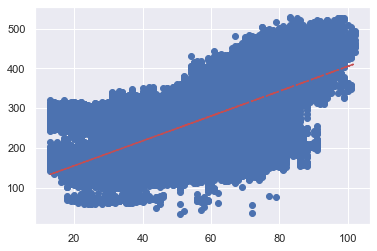

In [28]:
y_pred = linear_regression.intercept_[0] + linear_regression.coef_[0][0] * X.values.flatten()

# dibujar los datos
plt.plot(X.values.flatten(),y.values.flatten(),'o')
# dibujar recta estimada
plt.plot(X.values.flatten(), y_pred, '-.r')

In [29]:
linear_regression.score(X,y)

0.34227632837433897

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [31]:
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)

LinearRegression()

In [32]:
linear_regression.score(X_test,y_test)

0.34449062360005034

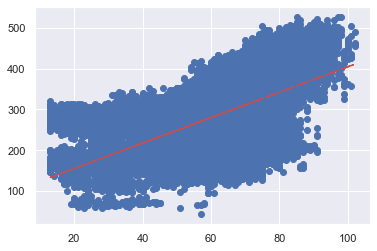

In [33]:
y_pred = linear_regression.intercept_[0] + linear_regression.coef_[0][0] * X_test.values.flatten()

# dibujar los datos
plt.plot(X_test.values.flatten(),y_test.values.flatten(),'o')
# dibujar recta estimada
plt.plot(X_test.values.flatten(), y_pred, '-.r')

### Caso datos extremos

In [34]:
Xf = pd.DataFrame(df_limpio['OAT (F)'])
yf = pd.DataFrame(df_limpio['Power (kW)'])

linear_regression_f = LinearRegression()
linear_regression_f.fit(Xf,yf)

LinearRegression()

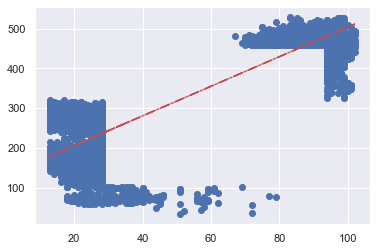

In [35]:
y_pred_f = linear_regression_f.intercept_[0] + linear_regression_f.coef_[0][0] * Xf.values.flatten()

# dibujar los datos
plt.plot(Xf.values.flatten(),yf.values.flatten(),'o')
# dibujar recta estimada
plt.plot(Xf.values.flatten(), y_pred_f, '-.r')

In [36]:
linear_regression.score(Xf,yf)

0.5037916296777797

In [37]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size=0.33, random_state=20)

In [38]:
linear_regression_ft = LinearRegression()
linear_regression_ft.fit(Xf_train,yf_train)

LinearRegression()

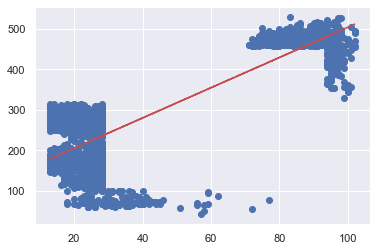

In [39]:
y_pred_ft = linear_regression_ft.intercept_[0] + linear_regression_ft.coef_[0][0] * Xf_test.values.flatten()

# dibujar los datos
plt.plot(Xf_test.values.flatten(),yf_test.values.flatten(),'o')
# dibujar recta estimada
plt.plot(Xf_test.values.flatten(), y_pred_ft, '-.r')

In [40]:
linear_regression.score(Xf_test,yf_test)

0.4987331986562268

El nivel de precisión que se alcanza cuando solo tomamos los datos cuando en la temperatura o en la energía sobrepasan dos desviaciones estandar es apreciable, que nos da una idea de que el ajuste es posible, pero con estos datos no es conclusivo, sea para rechazar la hipótesis o asegurarla, o sea no significativo en verdad, tanto cuando hacemos el ajuste con todos los datos, cómo cuando hacemos separando en conjunto de entrenamiento y prueba (teniendo para ambos puntajes bastante similares) Para el caso de los datos generales, igualmente vemos un ajuste de carácter directamente proporcional que relaciona los datos, pero debido a la alta dispersión que existe en los valores más usuales, o sea aquellos que se encuentran en dos desviacioens estándares ambos, nuestro puntaje $R^2$ no es tan bueno como en el caso donde solo tomamos los datos extremos de alguno de ellos, lo cuál nos da un contexto a la hipótesis inicial a la hipótesis de dependencia entre ambas variables y es que minimamente cuando las temperaturas son muy bajas o muy altas puede haber una relación directa con el consumo energético en los edificios.

## Aumentando predictores

Vamos a añadir algunos predictores cuántitativos como lo son, la hora y el mes en cuestión. Esto lo haremos solo para el dataset que no se hizo la hipótesis sobre valores extremos

In [41]:
df['hour']=df.index.hour
df['month']=df.index.month
df['day_week']=df.index.weekday
df['open_hours'] = np.where((df.index.hour >= 8) & (df.index.hour <= 22),1,0)

Además de esto extraigamos un último predictor cuántitativo, la semana del mes, para esto creemos una función usando isocalendar tal que. tomando el mes 

In [42]:
def WMExtractor(fechas):
    tgtdate = pd.to_datetime(fechas)

    days_this_month = calendar.mdays[fechas.month] #Nos dice la cantidad de días de cada mes 
    for i in range(1, days_this_month):
        d = dt.datetime(tgtdate.year, fechas.month, i) #Establece el día de la semana 
        if d.day - d.weekday() > 0: #Encuentra en qué día de la semana está
            startdate = d
            break
            
    return (tgtdate - startdate).days //7 + 1 #División entendiendo cantidad de día de la semana 

In [43]:
df['week_of_month']= df.index.to_series().apply(WMExtractor)

In [44]:
X_n = pd.DataFrame(df[['OAT (F)','hour','open_hours','day_week','month','week_of_month']])
y_n = pd.DataFrame(df['Power (kW)'])

In [45]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.3, random_state=20)

In [46]:
linear_regression_n = LinearRegression()
linear_regression_n.fit(X_train_n,y_train_n)

LinearRegression()

In [47]:
linear_regression_n.score(X_test_n,y_test_n)

0.7240842876283452

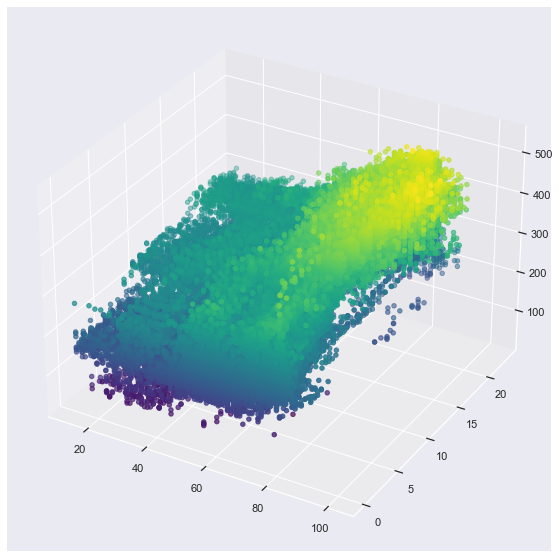

In [48]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_n['OAT (F)'], X_train_n['hour'], y_train_n, c=y_train_n, cmap='viridis')

Aplicando estos mismos predictores sobre nuestro conjunto depurado solo para valores extremos

In [49]:
df_limpio['hour']=df_limpio.index.hour
df_limpio['month']=df_limpio.index.month
df_limpio['day_week']=df_limpio.index.weekday
df_limpio['open_hours'] = np.where((df_limpio.index.hour >= 8) & (df_limpio.index.hour <= 22),1,0)

In [50]:
df_limpio['week_of_month']= df_limpio.index.to_series().apply(WMExtractor)

In [51]:
X_nl = pd.DataFrame(df_limpio[['OAT (F)','hour','open_hours','day_week','month','week_of_month']])
y_nl = pd.DataFrame(df_limpio['Power (kW)'])

In [52]:
X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(X_nl, y_nl, test_size=0.3, random_state=20)

In [53]:
linear_regression_nl = LinearRegression()
linear_regression_nl.fit(X_train_nl,y_train_nl)

LinearRegression()

In [54]:
linear_regression_nl.score(X_test_nl,y_test_nl)

0.8996189801364669

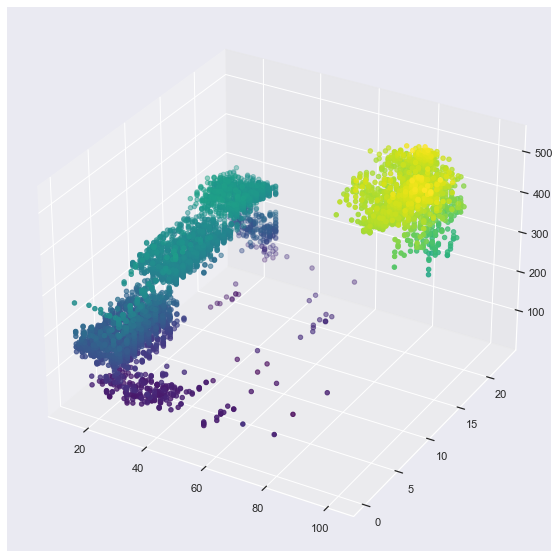

In [55]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train_nl['OAT (F)'], X_train_nl['hour'], y_train_nl, c=y_train_nl, cmap='viridis')

Como podemos ver para el caso de usar el conjunto de datos filtrado, una vez establecemos los nuevos predictores tenemos un ajuste muchísimo mejor, que llega a puntos de ajuste bastante altos $R^2=0.9$, lo cual nos habla muy positivamente de cómo al tener por ejemplo estos datos extraibles de la fecha se puede establecer una mejor relación de los datos, esto quiere decir, si queremos establecer el consumo energético en condiciones de temperatura bastante altas o bastante bajas, nuestra probabilidad de tener una buena predicción es bastante alta. el hecho que no sea perfecto es un buen indicio respecto a los datos ya que siempre es debido desconfiar de este tipo de ajustes "Perfectos" en estadística. Por otra parte el conjunto de datos completo también nos da ahora con estos nuevos predictores un ajuste bastante bueno si comparamos con la dipsersión inicial de nuestros datos, lo cuál nos habla de la relación tan estrecha qué hay del consumo energético con variables temporales cuántitativas asociadas (dígase la hora, el mes, la semana del mes) o cualitativas como la hora en qué se hace la suposición que la tienda abre, o si se quisiera volver la hora también una variable cualitativa, lo cuál haría qué empezáramos a tener de variable de entrada la misma hora y así mismo afectando posiblemente positivamente el ajuste o negativa o de ninguna manera el ajuste si encontramos cuestiones de colinealidad, aunque con esto, pudiendo establecer relaciones directas con cada hora en particular y poder establecer nuevas conclusiones.

Cuando todo esto se une en el modelo podemos aseverar dos cosas: Dado el índice de éxito de los datos completos ($R^2=0.72$) y el hecho de que se incluye todo el espectro, el modelo puede ser aplicado entendiendo sus márgenes de éxito, esto quiere decir qué, hemos encontrado relación entre la temperatura y el consumo energético dado lo que nos arroja el ajuste de los datos filtrados y además al incluir otro tipo de variables hemos encontrado no solo nuevas relaciones de datos como la hora, el mes, etc y el consumo energético sino que el ajuste del modelo hace posible ser implementado para inferir valores numéricos, eso sí, sabiendo qué índice de éxito hay y cómo es más favorable para valores más extremos de la temperatura. 

Esta tarea fue realizada por el estudiante:

Santiago Andrés Pérez Acevedo <br>
1017246165 <br>
Aprendizaje estadístico - 2021-1 <br>
